In [29]:
#Importações
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [30]:
#Carregar imagem
def select_image(filename):
    image = Image.open(filename)# Abrir arquivo
    image = image.convert('RGB')#transformar em RGB
    image = image.resize((160,160))
    return np.asarray(image)

In [31]:
#Carregando uma classe
def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos

    for filename in listdir(diretorio):

        path = diretorio + filename

        try:
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

In [32]:
# Selecionar o Dataset
def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + subdir + '\\'

        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

In [33]:
faces_dataset = "C:\\Users\\NAJA INFORMATICA\\Desktop\\Nova pasta\\fotos\\" # Colocar o caminho absoluto do dataset
imagens, labels  = select_data_set(faces_dataset)
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

In [34]:
labels[300]

'neutral'

In [35]:
#Transformar em binario Happy e neutro
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

labels[1]

array([1., 0.], dtype=float32)

In [36]:
#Definir hiperparametros

batch_size   = 32
input_shape  = (160, 160, 3)
random_state = 42
alpha        = 1e-5
epoch        = 30

In [37]:
#Callback -> treinamento usando keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [38]:
#Salva o módelo em cada epoca que é executada
filepath="detector.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [39]:
#Evitar plateau -> aumentar a acuracia 
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

In [40]:
callbacks = [checkpoint, lr_reduce]

In [42]:
#Dividir o dataset
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

In [43]:
#Aumentar dados
train_datagen = ImageDataGenerator(
        horizontal_flip= True,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
        )

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

In [44]:
# Transfer learning
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

In [45]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [46]:
# Dimuir parametros da vgg

conv_base.trainable = True
set_trainable = False

In [47]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [48]:
model = models.Sequential()
model.add(conv_base) #vgg19
model.add(layers.GlobalAveragePooling2D()) # reduzir a resolução
model.add(layers.BatchNormalization()) #Aumentar a estabilidade da rede neural
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))# camada densa, número de neuronios
model.add(layers.Dropout(0.5))# generalizar a rede neural
model.add(layers.Dense(2, activation='softmax')) # camada de saida 

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6

In [50]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

In [51]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.8135 - acc: 0.5437
Epoch 00001: val_acc improved from -inf to 0.53175, saving model to detector.h5
15/15 [==============================] - 152s 10s/step - loss: 0.8135 - acc: 0.5437 - val_loss: 7.1817 - val_acc: 0.5317
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.7555 - acc: 0.5584
Epoch 00002: val_acc did not improve from 0.53175
15/15 [==============================] - 146s 10s/step - loss: 0.7555 - acc: 0.5584 - val_loss: 8.2772 - val_acc: 0.4603
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.7176 - acc: 0.5138
Epoch 00003: val_acc did not improve from 0.53175
15/15 [==============================] - 146s 10s/step - loss: 0.7176 - acc: 0.5138 - val_loss: 4.0480 - val_acc: 0.4683
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 0.6887 - acc: 0.5605
Epoch 00004: val_acc did 

15/15 [==============================] - 146s 10s/step - loss: 0.6743 - acc: 0.5966 - val_loss: 0.6494 - val_acc: 0.6190
Epoch 30/30
15/15 [==============================] - ETA: 0s - loss: 0.6553 - acc: 0.5987
Epoch 00030: val_acc did not improve from 0.61905
15/15 [==============================] - 146s 10s/step - loss: 0.6553 - acc: 0.5987 - val_loss: 0.6487 - val_acc: 0.6190


In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

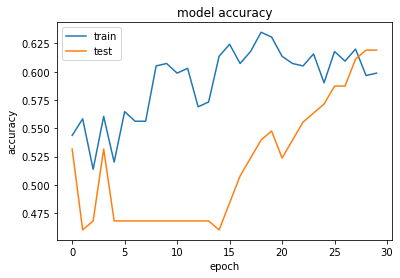

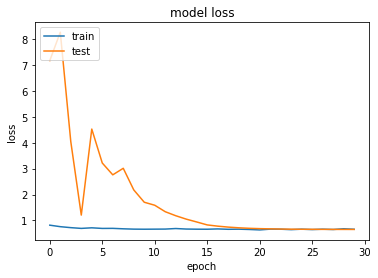

In [53]:
# taxa de acurácia
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# taxa de erro
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

In [55]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

Acurácia: 0.6190
Sensitividade: 0.8136
Especificidade: 0.4478


ModuleNotFoundError: No module named 'mlxtend'